In [125]:
from sqlalchemy import create_engine, MetaData, Table
from urllib.parse import quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [126]:
username = 'team25'
password = quote('te@mzs')
database = 'team25'
host = 'giniewicz.it'
port = '3306'

engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

In [127]:
metadata = MetaData()
games_for_sale = Table('games_for_sale', metadata, autoload_with = engine)

connection = engine.connect()

In [128]:
query = games_for_sale.select()
result = connection.execute(query)
df = pd.DataFrame(result.fetchall(), columns=result.keys())
df.head()

,game_id,name,description,min_players,max_players,avg_time,avg_rating,age,availability,category,price
0,1,Die Macher,Players represent political parties attempting...,3,5,240,7.65016,14,5364,"Economic, Negotiation, Political",421.80
1,3,Samurai,Dispute the favor of three different castes in...,2,4,60,7.43674,10,12860,"Abstract Strategy, Medieval",555.00
2,4,Tal der Könige,Bid for colorful blocks to build pyramids in t...,2,4,60,6.59261,12,549,Ancient,195.36
3,5,Acquire,"Invest, divest, and stage hostile takeovers in...",2,6,90,7.35752,12,20313,Economic,421.80
4,7,Cathedral,Outwit your opponent and play all your pieces ...,2,2,20,6.50389,8,4929,Abstract Strategy,199.80


## Jakie kategorie występują najczęściej?

In [129]:
categories = df.category.values
splitted = []
for category in categories:
    category_split = category.split(', ')
    for indice in category_split:
        splitted.append(indice)
splitted = np.array(splitted)
splitted_series = pd.DataFrame(splitted)
splitted_series.columns = ['Category']
splitted_series

,Category
0,Economic
1,Negotiation
2,Political
3,Abstract Strategy
4,Medieval
...,...
10344,Nautical
10345,Novel-based
10346,Pirates
10347,Territory Building


In [130]:
print('Liczba unikatowych kategorii: ' + str(len(splitted_series.Category.unique())))

Liczba unikatowych kategorii: 84


In [131]:
popularity

,Category,Count
0,Card Game,1014
1,Wargame,695
2,Fantasy,600
3,Economic,433
4,Fighting,402
...,...,...
79,American Indian Wars,8
80,Music,6
81,Math,5
82,Korean War,3


In [134]:
popularity =splitted_series.value_counts().reset_index()
popularity.columns = ['Category', 'Count']
first10 = popularity[:10]

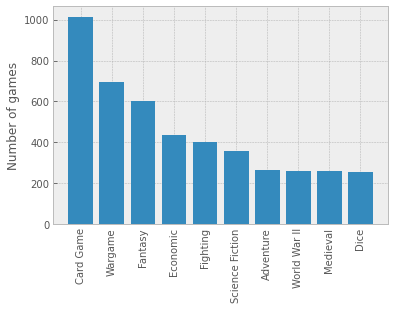

In [135]:
plt.style.use('bmh')
fig, ax = plt.subplots()
ax.bar(first10['Category'], first10['Count'])
ax.set_xticklabels(first10['Category'], rotation = 90)
ax.set_ylabel('Number of games')
plt.show()

## Co najbardziej wpływa na ocenę gry?

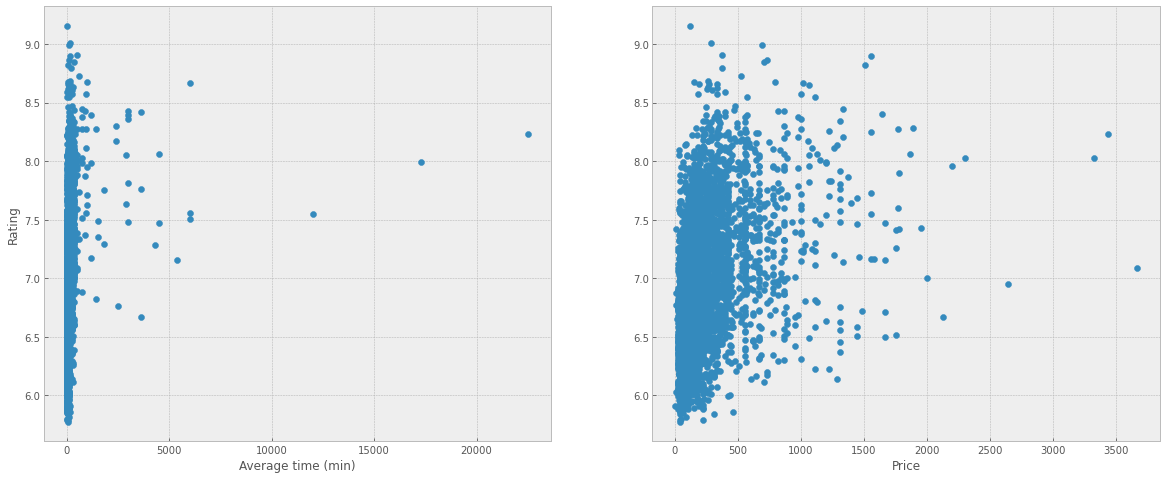

In [146]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].scatter(df.avg_time, df.avg_rating)
ax[0].set_xlabel('Average time (min)')
ax[1].scatter(df.price, df.avg_rating)
ax[1].set_xlabel('Price')
ax[0].set_ylabel('Rating')
plt.show()

In [ ]:
def del_outliers(df, data):
    q1 = np.quantile(data, .25)
    q3 = np.quantile(data, .75)
    iqr = q3 - q1
    filtered_data = data[q1 - 1.5*iqr < data < q3 + 1.5*iqr]
    return filtered_data